## Writing your own training and evaluation loops
#### The fit() workflow strikes a nice balance between ease of use and flexibility. The built-in fit() workflow is solely focused on supervised learning: a setup where there are known targets (also called labels or annotations) associated with your input data, and where you compute your loss [as a function] between these targets and the model’s predictions.
#### There are other setups where no explicit targets are present, such as generative learning, self-supervised learning (where targets are obtained from the inputs), and reinforcement learning (where learning is driven by occasional “rewards,” much like training a dog).
#### Whenever you find yourself in a situation where the built-in fit() is not enough, you will need to write your own custom training logic.
####  The pseudo-code typical training loop look like this:

#####  1) Run the forward pass (compute the model’s output) inside a gradient tape to obtain a loss value for the current batch of data
##### 2) Retrieve the gradients of the loss with regard to the model’s weights.
##### 3) Update the model’s weights so as to lower the loss value on the current batch of data.

### Training versus inference
       

#### Training vs. Inference Behavior: 
    Some Keras layers, like Dropout and BatchNormalization, act differently during training and inference (when making predictions). They have a training argument in their call() method. Calling dropout(inputs,training=True) will drop some activation entries, while calling dropout(inputs,training=False) does nothing. Crucially, remember to set training=True when calling your model (Functional or Sequential) during the forward pass in your training loop. This ensures these layers behave correctly during training.
#### Trainable vs. Non-Trainable Weights: Keras models and layers have two types of weights:
    1) Trainable weights: These are the standard weights that are updated by backpropagation (e.g., kernel and bias in a Dense layer).
    2) Non-trainable weights: These are updated during the forward pass by the layer itself. A built-in example is the BatchNormalization layer, which uses non-trainable weights to track the mean and standard deviation of the input data.
#### Gradient Calculation: 
    When calculating gradients, use 
    tape.gradient(loss, model.trainable_weights) instead of 
    tape.gradient(loss, model.weights). 
    This ensures you only compute gradients for the weights that should be updated during training.

In [21]:
import keras
from keras.datasets import mnist
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

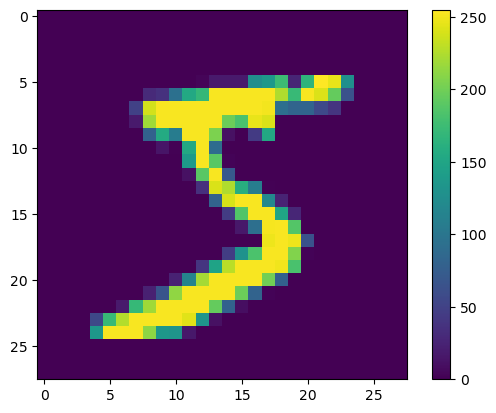

In [23]:
(images, labels), (test_images, test_labels) = mnist.load_data()

plt.figure()
plt.imshow(images[0])
plt.colorbar()
plt.grid(False)
plt.show()

images = images.reshape((60000, 28*28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28*28)).astype("float32") / 255

train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [24]:
import tensorflow as tf
import keras
def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, Training=True)
        loss = loss_function(targets, predictions)
        gradients = tape.gradients(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(model.trainable_weights, gradients))

### Low-level usage of metrics
#### In a low-level training loop, you will probably want to leverage Keras metrics. call `update_state(y_true, y_pred)` for each batch of targets and predictions, and then use `result()` to query the current metric value. Remember to use `metric.reset_state()` when you want to reset the current results (at the start of a training epoch or at the start of evaluation)

In [25]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

result: 1.00


### A complete training and evaluation loop
#### Writing a step-by-step training loop: the training step function

In [63]:
tf.compat.v1.enable_eager_execution()
print(tf.executing_eagerly())

model = get_mnist_model()

loss_fn = keras.losses.SparseCategoricalCrossentropy() # prepare loss function
optimizer = keras.optimizers.RMSprop()                 # prepare the optimizer
metrics = [keras.metrics.SparseCategoricalAccuracy()]  # prepare the list of metrics to monitor
loss_tracking_metric = keras.metrics.Mean()            # prepare a Mean metric tracker to keep track of the loss average

def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        # run the forward pass. Note that we pass training=True
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    
    # run the backward pass Note that we use model.trainable_weights.
    gradients = tape.gradient(loss, model.trainable_weights) # find the direction in the curve that minimizes the loss
    optimizer.apply_gradients(zip(gradients, model.trainable_weights)) # move in the opposite direction of the gradients W = W - LR*gradient 

    # keep track of metrics
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()

    # keep track of loss average
    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs
        

True


#### Writing a step-by-step training loop: resetting the metrics
##### We will need to reset the state of our metrics at the start of each epoch and before running evaluation. Here’s a utility function to do it.

In [27]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

#### Writing a step-by-step training loop: the loop itself

In [34]:
# Using tf.data.Dataset object to turn our NumPy data into an iterator that iterates over the data in batches of size 32

training_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3

for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9136
...loss: 0.2924
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9526
...loss: 0.1604
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9648
...loss: 0.1298


##### Evaluation loop: a simple for loop that repeatedly calls a test_step() function, which processes a single batch of data. The test_step() function is just a subset of the logic of train_step(). It omits the code that deals with updating the weights of the model—that is to say, everything involving the GradientTape and the optimizer.
##### while you are debugging your code, prefer running it eagerly, without any @tf.function decorator. It’s easier to track bugs this way. Once your code is working and you want to make it fast, add a @tf.function decorator to your training step and your evaluation step—or any other performance-critical function. 

In [39]:
@tf.function()
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)

reset_metrics()

for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items(): 
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9692
...val_loss: 0.1198


### Leveraging fit() with a custom training loop
#### Implementing a custom training step to use with fit()

In [53]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
#This metric object will be used to track the average of per-batch losses during training and evaluation.
loss_tracker = keras.metrics.Mean(name="loss")

class CustomModel(keras.Model):
    # We override the train_step method.
    
    def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            # We use self(inputs, training=True) instead of model(inputs, training=True), 
            # since our model is the class itself.

            predictions = self(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(gradients, self.trainable_weights))

        #  We update the loss tracker metric that tracks the average of the loss.
        loss_tracker.update_state(loss)
        
        # We return the average loss so far by querying the loss tracker metric
        return {"loss": loss_tracker.result()}

    # Any metric you would like to reset across epochs should be listed here.
    @property
    def metrics(self):
        return [loss_tracker]
       


True


#####  We can now instantiate our custom model, compile it (we only pass the optimizer, since the loss is already defined outside of the model), and train it using fit() as usual

In [56]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)

model = CustomModel(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop())
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4519
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1588
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1306


### Notes
    1) This pattern does not prevent you from building models with the Functional API. You can do this whether you’re building Sequential models, Functional API models, or subclassed models.
    2) You don’t need to use a @tf.function decorator when you override train_step—the framework does it for you.
    3) After you’ve called compile(), you get access to the following:
        a) self.compiled_loss—The loss function you passed to compile()
        b) self.compiled_metrics—A wrapper for the list of metrics you passed, which allows you to call           self.compiled_metrics.update_state() to update all of your metrics at once.
        c) self.metrics—The actual list of metrics you passed to compile(). Note that it also includes a metric that tracks the loss, similar to what we did manually with our loss_tracking_metric earlier

In [64]:
class CustomModel(keras.Model):
     def train_step(self, data):
        inputs, targets = data
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.compiled_loss(targets, predictions)   
        gradients = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        self.compiled_metrics.update_state(targets, predictions)  
        return {m.name: m.result() for m in self.metrics}

In [65]:
inputs = keras.Input(shape=(28 * 28,))
features = layers.Dense(512, activation="relu")(inputs)
features = layers.Dropout(0.5)(features)
outputs = layers.Dense(10, activation="softmax")(features)
model = CustomModel(inputs, outputs)
model.compile(optimizer=keras.optimizers.RMSprop(),
      loss=keras.losses.SparseCategoricalCrossentropy(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=3)

Epoch 1/3


\\?\C:\Users\shrim\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:640: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - sparse_categorical_accuracy: 0.8639 - loss: 0.1000
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - sparse_categorical_accuracy: 0.9522 - loss: 0.1000
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - sparse_categorical_accuracy: 0.9634 - loss: 0.1000
